Desarrollamos una  PINN para resolver la ecuación de ondas en una y dos dimensiones utilizando la librería *PyTorch*.

La ecuación de ondas es una ecuación derivadas parciales que describe la propagación de ondas, tales como ondas sonoras, electromagnéticas o mecánicas, en un medio físico.

En **una dimensión espacial**, la ecuación se expresa como

\begin{equation}
\frac{\partial^2 u}{\partial t^2} = c^2 \frac{\partial^2 u}{\partial x^2},
\end{equation}

donde $u = u(x,t)$ representa el campo de onda y $c$ es la velocidad de propagación de la onda en el medio. Las condiciones iniciales y de contorno consideradas son las siguientes:
* Condición de desplazamiento inicial: $u(x, 0) = \sin(\pi x)$
* Condición de velocidad inicial: $\frac{\partial u}{\partial t}(x, 0) = 0$
* Condiciones de frontera (tipo Dirichlet): $u(x,t) = 0 \quad x \in \partial \Omega$

Extendiendo el problema a **dos dimensiones espaciales**, la ecuación tiene la forma:

\begin{equation}
\frac{\partial^2 u}{\partial t^2} = c^2 \left( \frac{\partial^2 u}{\partial x^2} + \frac{\partial^2 u}{\partial y^2} \right),
\end{equation}

con $u = u(x,y,t)$.

Las condiciones iniciales y de frontera juegan un papel fundamental para garantizar la unicidad y estabilidad de la solución.

En particular, se imponen:
* Condición de desplazamiento inicial: $u(x,y,0) = f(x,y)$,
* Condición de velocidad inicial: $\frac{\partial u}{\partial t}(x,y,0) = 0$,

y condiciones de contorno que pueden ser de tipo Dirichlet, Neumann, o mixtas según la configuración física del problema. Por ejemplo, para un dominio rectangular $\Omega = \{ (x,y) : x \in [a,b], y \in [c,d] \}$, se puede imponer una condición de frontera de tipo Dirichlet, es decir,
$$u(x,y,t) = 0 \quad (x,y) \in \partial \Omega$$
donde $\partial \Omega$ denota la frontera del dominio.

El objetivo es primero implementar y validar una solución PINN para la ecuación de ondas en una dimensión, para posteriormente extenderla a dos dimensiones y comparar resultados. La metodología emplea la minimización de una función de pérdida que incorpora la ecuación diferencial y las condiciones iniciales y de frontera, permitiendo resolver el problema sin discretizar explícitamente el dominio espacial ni temporal.

In [1]:
import numpy as np                             # Calculo numerico
import torch                                   # Biblioteca principal
import torch.nn as nn                          # Definicion red neuronal
import torch.optim as optim                    # Optimizacion
import torch.nn.init as init                   # Inicializacion
import torch.autograd as grad                  # Calculo gradientes
from torch import autograd
import matplotlib.pyplot as plt                # Libreria graficos
from matplotlib.animation import FuncAnimation # Animaciones
import time                                    # Visualizacion tiempo

In [2]:
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)} is available.")
else:
    print("No GPU available. Training will run on CPU.")

GPU: Tesla T4 is available.


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
# Parámetros
c = 1.0  # velocidad de propagación

## 1 DIMENSIÓN

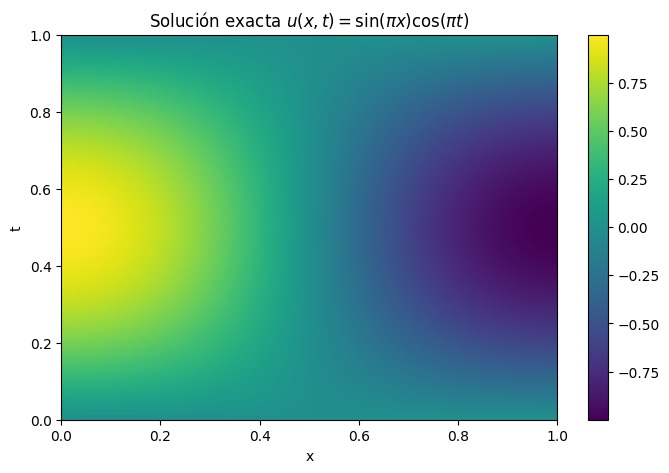

In [5]:
# Solución exacta:
# === Visualización de la solución exacta u(x,t) = sin(pi x) * cos(pi c t) ===

# Crear la malla (x,t)
x_vals = torch.linspace(0, 1, 200)
t_vals = torch.linspace(0, 1, 200)
X, T = torch.meshgrid(x_vals, t_vals, indexing='ij')  # [200,200]

# Solución exacta
U_exact = torch.sin(np.pi * X) * torch.cos(np.pi * c * T)

# Dibujar con imshow
fig, ax = plt.subplots(figsize=(8, 5))
cmap = ax.imshow(U_exact.numpy(), extent=[0, 1, 0, 1], origin='lower', aspect='auto', cmap='viridis')
ax.set_xlabel('x')
ax.set_ylabel('t')
ax.set_title('Solución exacta $u(x,t) = \sin(\pi x)\cos(\pi t)$')
plt.colorbar(cmap, ax=ax)
plt.show()

In [6]:
# Red neuronal
class PINN1D(nn.Module):
    def __init__(self, layers):
        super().__init__()
        self.model = nn.Sequential()
        for i in range(len(layers) - 1):
            self.model.add_module(f"layer_{i}", nn.Linear(layers[i], layers[i+1]))
            if i < len(layers) - 2:
                self.model.add_module(f"act_{i}", nn.Tanh())

    def forward(self, x, t):
        return self.model(torch.cat((x, t), dim=1))

In [7]:
# Derivadas necesarias
def derivatives(u, x, t):
    u_t = autograd.grad(u, t, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    u_tt = autograd.grad(u_t, t, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    u_x = autograd.grad(u, x, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    u_xx = autograd.grad(u_x, x, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    return u_tt, u_xx

In [8]:
# Función de pérdida
def loss_fn(model, x_f, t_f, x_ic, t_ic, u_ic, u_t_ic, x0_bc, x1_bc, t_bc):
    x_f.requires_grad = True
    t_f.requires_grad = True
    u_pred = model(x_f, t_f)
    u_tt, u_xx = derivatives(u_pred, x_f, t_f)
    res_pde = u_tt - c**2 * u_xx
    loss_pde = torch.mean(res_pde**2)

    # Condición inicial: u(x,0) = f(x)
    u_ic_pred = model(x_ic, t_ic)
    loss_ic = torch.mean((u_ic_pred - u_ic)**2)

    # Velocidad inicial: ∂u/∂t(x,0) = 0
    t_ic.requires_grad = True
    u_t_pred = autograd.grad(model(x_ic, t_ic), t_ic, torch.ones_like(u_ic_pred), create_graph=True)[0]
    loss_ut = torch.mean((u_t_pred - u_t_ic)**2)

    # Condiciones de frontera Dirichlet: u(0,t) = u(1,t) = 0
    u0 = model(x0_bc, t_bc)
    u1 = model(x1_bc, t_bc)
    loss_bc = torch.mean(u0**2) + torch.mean(u1**2)

    return loss_pde + loss_ic + loss_ut + loss_bc

In [9]:
# Modelo y entrenamiento
model = PINN1D([2, 60, 60, 1]).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [10]:
def generate_training_data(N_f, N_ic, N_bc):
    # Collocation points (x,t) para EDP
    x_f = torch.rand(N_f, 1).to(device)
    t_f = torch.rand(N_f, 1).to(device)

    # Condición inicial: u(x,0) = sin(pi x)
    x_ic = torch.linspace(0, 1, N_ic).view(-1, 1).to(device)
    t_ic = torch.zeros_like(x_ic).to(device)
    u_ic = torch.sin(np.pi * x_ic).to(device)

    # Velocidad inicial: ∂u/∂t(x,0) = 0
    u_t_ic = torch.zeros_like(x_ic).to(device)

    # Condiciones de frontera: u(0,t) = u(1,t) = 0
    t_bc = torch.linspace(0, 1, N_bc).view(-1, 1).to(device)
    x0_bc = torch.zeros_like(t_bc).to(device)
    x1_bc = torch.ones_like(t_bc).to(device)

    return x_f, t_f, x_ic, t_ic, u_ic, u_t_ic, x0_bc, x1_bc, t_bc

In [11]:
# Generar datos
x_f, t_f, x_ic, t_ic, u_ic, u_t_ic, x0_bc, x1_bc, t_bc = generate_training_data(10000, 100, 100)

for epoch in range(5000):
    optimizer.zero_grad()
    loss = loss_fn(model, x_f, t_f, x_ic, t_ic, u_ic, u_t_ic, x0_bc, x1_bc, t_bc)
    loss.backward()
    optimizer.step()
    if epoch % 500 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.6f}")

/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at /pytorch/aten/src/ATen/cuda/CublasHandlePool.cpp:180.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Epoch 0, Loss: 0.369908
Epoch 500, Loss: 0.001432
Epoch 1000, Loss: 0.001303
Epoch 1500, Loss: 0.000124
Epoch 2000, Loss: 0.000048
Epoch 2500, Loss: 0.000031
Epoch 3000, Loss: 0.000023
Epoch 3500, Loss: 0.000020
Epoch 4000, Loss: 0.000015
Epoch 4500, Loss: 0.000014


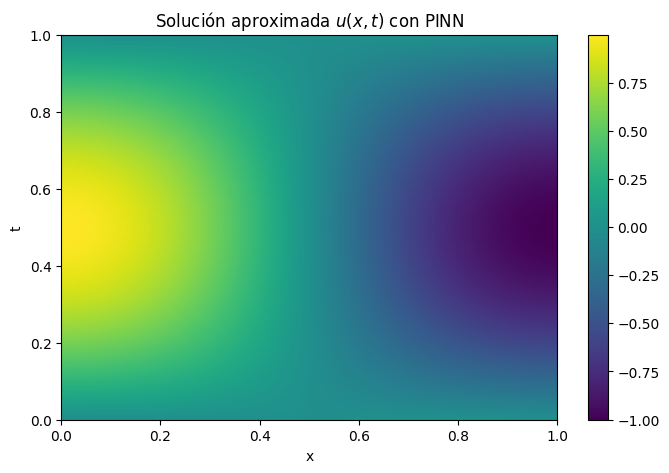

In [12]:
# ======================
# Visualización tipo imshow (colormap)
# ======================

x_vals = torch.linspace(0, 1, 200).to(device)
t_vals = torch.linspace(0, 1, 200).to(device)
X, T = torch.meshgrid(x_vals, t_vals, indexing='ij')  # (200x200)
x_flat = X.reshape(-1, 1)
t_flat = T.reshape(-1, 1)

with torch.no_grad():
    U_pred = model(x_flat, t_flat).cpu().numpy()

U = U_pred.reshape(200, 200)

fig, ax = plt.subplots(figsize=(8, 5))
c2 = ax.imshow(U, extent=[0,1,0,1], origin='lower', aspect='auto', cmap='viridis')
ax.set_xlabel('x')
ax.set_ylabel('t')
ax.set_title('Solución aproximada $u(x,t)$ con PINN')
plt.colorbar(c2, ax=ax)
plt.show()

## 2 DIMENSIONES

### Definición red neuronal:

In [13]:
class ondas(nn.Module):
    def __init__(self, layers=[3, 60, 60, 60, 60, 1]):

        super(ondas, self).__init__()
        self.activation = nn.Tanh()

        # Lista conexión entre capas (totalmente conectadas)
        layer_list = []
        for i in range(len(layers)-1):
            layer_list.append(nn.Linear(layers[i], layers[i+1]))
        self.layers = nn.ModuleList(layer_list)

        # Inicialización de pesos
        for m in self.layers:
            if isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight)
                nn.init.zeros_(m.bias)

    def forward(self, x):
        """
        x forma: (batch_size, 3)  # i.e. [x, y, t]
        """
        for i in range(len(self.layers) - 1):
            x = self.layers[i](x)
            x = self.activation(x)
        x = self.layers[-1](x)
        return x

In [14]:
def ondas_pde_residual(x, y, t, model, c):
    """
    PDE residual:
    r = u_tt - c^2 (u_xx + u_yy)
    x, y, t tensores con forma (N,1)
    """

    x.requires_grad = True
    y.requires_grad = True
    t.requires_grad = True

    u = model(torch.cat([x, y, t], dim=1))  # Forma (N, 1)

    # Primeras derivadas
    u_t = torch.autograd.grad(u, t, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    u_x = torch.autograd.grad(u, x, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    u_y = torch.autograd.grad(u, y, grad_outputs=torch.ones_like(u), create_graph=True)[0]

    # Segundas derivadas
    u_tt = torch.autograd.grad(u_t, t, grad_outputs=torch.ones_like(u_t), create_graph=True)[0]
    u_xx = torch.autograd.grad(u_x, x, grad_outputs=torch.ones_like(u_x), create_graph=True)[0]
    u_yy = torch.autograd.grad(u_y, y, grad_outputs=torch.ones_like(u_y), create_graph=True)[0]

    # PDE residual
    residual = u_tt - c**2 * (u_xx + u_yy)
    return residual

### Puntos de colocacion:

In [15]:
# Dominio (ejemplo): x en [0,1], y en [0,1], t en [0,1]
N_collocation = 5000  # Interior
N_boundary = 200      # Frontera
N_initial = 200       # Tiempo inicial

# Puntos de colocación en el interior del dominio
x_collocation = torch.rand(N_collocation, 1).to('cuda')
y_collocation = torch.rand(N_collocation, 1).to('cuda')
t_collocation = torch.rand(N_collocation, 1).to('cuda')

# Puntos de colocación en la frontera del dominio (condiciones tipo Dirichlet en x=0 o x=1, y=0 o y=1)

x_bc = torch.cat([
    torch.zeros(N_boundary//4,1),
    torch.ones(N_boundary//4,1),
    torch.rand(N_boundary//4,1),
    torch.rand(N_boundary//4,1)
], dim=0).to('cuda')
y_bc = torch.cat([
    torch.rand(N_boundary//4,1),
    torch.rand(N_boundary//4,1),
    torch.zeros(N_boundary//4,1),
    torch.ones(N_boundary//4,1)
], dim=0).to('cuda')
t_bc = torch.rand(N_boundary,1).to('cuda')

# Función para las condiciones de contorno
u_bc = torch.zeros(N_boundary,1).to('cuda')

# Puntos iniciales (t=0)
x_ic = torch.rand(N_initial,1).to('cuda')
y_ic = torch.rand(N_initial,1).to('cuda')
t_ic = torch.zeros(N_initial,1).to('cuda')

# Desplazamiento inicial f(x,y)=sin(pi*x)*sin(pi*y)
u_ic = torch.sin(np.pi * x_ic) * torch.sin(np.pi * y_ic)  # Forma [N_initial,1]
u_ic = u_ic.to('cuda')

In [16]:
model = ondas(layers=[3, 60, 60, 60, 60, 1]).to('cuda')
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

####Función de pérdida:

La función de pérdida total utilizada en el entrenamiento de la PINN combina dos términos principales: la pérdida asociada a la ecuación diferencial (residuo de la EDP) y la pérdida asociada a las condiciones iniciales y de contorno.

* Pérdida Física (Residuo de la EDP)

La pérdida correspondiente al cumplimiento de la ecuación de ondas en el dominio espacio-temporal se define como:

\begin{equation}
\mathcal{L}_F = \left\| \frac{\partial^2 \hat{u}}{\partial t^2} - c^2 \left(\frac{\partial^2 \hat{u}}{\partial x^2} + \frac{\partial^2 \hat{u}}{\partial y^2}\right) \right\|^2,
\end{equation}

evaluada en puntos de colocación aleatorios dentro del dominio espacio-temporal.

* Pérdida por Condiciones Iniciales y de Contorno

La pérdida asociada a las condiciones iniciales y de contorno se expresa como:

\begin{equation}
\mathcal{L}_B  = \left\|\hat{u}(x, y, 0;\theta) - f(x,y)\right\|^2 + \left\|\left.\frac{\partial \hat{u}}{\partial t}\right|_{t=0} - 0\right\|^2 + \left\|\left. \hat{u} \right|_{\partial \Omega} - 0\right\|^2,
\end{equation}

donde el primer término impone la condición de desplazamiento inicial, el segundo la condición de velocidad inicial, y el tercero las condiciones de contorno de tipo Dirichlet.

* Pérdida Total

La función de pérdida total a minimizar durante el entrenamiento de la red neuronal es la suma de los dos términos anteriores:

\begin{equation}
\mathcal{L}(\theta) = \mathcal{L}_F + \mathcal{L}_B.
\end{equation}


In [17]:
def loss_func():
    # PÉRDIDA PDE residual
    r = ondas_pde_residual(x_collocation, y_collocation, t_collocation, model, c)
    loss_pde = torch.mean(r**2)

    # PÉRDIDA condicion de contorno (Dirichlet)
    u_pred_bc = model(torch.cat([x_bc, y_bc, t_bc], dim=1))
    loss_bc = torch.mean((u_pred_bc - u_bc)**2)

    # PÉRDIDA condición inicial
    u_pred_ic = model(torch.cat([x_ic, y_ic, t_ic], dim=1))
    loss_ic = torch.mean((u_pred_ic - u_ic)**2)

    # Velocidad inicial = 0
    # (u_t en t=0)
    x_ic.requires_grad=True
    y_ic.requires_grad=True
    t_ic.requires_grad=True
    u_pred_ic_for_velocity = model(torch.cat([x_ic, y_ic, t_ic], dim=1))
    u_t_ic = torch.autograd.grad(u_pred_ic_for_velocity, t_ic,
                                 grad_outputs=torch.ones_like(u_pred_ic_for_velocity),
                                 create_graph=True)[0]
    loss_ic_velocity = torch.mean(u_t_ic**2)

    # PÉRDIDA TOTAL
    loss = loss_pde + loss_bc + loss_ic + loss_ic_velocity
    loss = loss.to('cuda')
    return loss

### Entrenamiento red neuronal:

In [18]:
losses = []
num_epochs = 30000
start = time.time()

for epoch in range(num_epochs):
    optimizer.zero_grad()
    loss = loss_func()
    loss.backward()
    optimizer.step()
    if epoch % 1000 == 0:
        losses.append(loss.item())
        print(f'Epoch {epoch}, Loss {loss.item():.6e}')
end = time.time()
print(f"Training completed in {end - start:.2f} seconds")

Epoch 0, Loss 1.930137e-01
Epoch 1000, Loss 1.419928e-02
Epoch 2000, Loss 8.109168e-03
Epoch 3000, Loss 6.393885e-03
Epoch 4000, Loss 5.392587e-03
Epoch 5000, Loss 4.390701e-03
Epoch 6000, Loss 3.430463e-03
Epoch 7000, Loss 2.473526e-03
Epoch 8000, Loss 1.867355e-03
Epoch 9000, Loss 4.685579e-03
Epoch 10000, Loss 1.189189e-03
Epoch 11000, Loss 1.689034e-03
Epoch 12000, Loss 7.991448e-04
Epoch 13000, Loss 7.594641e-04
Epoch 14000, Loss 6.071643e-04
Epoch 15000, Loss 6.285953e-04
Epoch 16000, Loss 4.758504e-04
Epoch 17000, Loss 1.040533e-03
Epoch 18000, Loss 3.925978e-04
Epoch 19000, Loss 3.988957e-03
Epoch 20000, Loss 3.654939e-04
Epoch 21000, Loss 3.772612e-04
Epoch 22000, Loss 9.050830e-03
Epoch 23000, Loss 1.551988e-03
Epoch 24000, Loss 2.744156e-04
Epoch 25000, Loss 3.945526e-04
Epoch 26000, Loss 2.862157e-04
Epoch 27000, Loss 2.483263e-04
Epoch 28000, Loss 2.395738e-04
Epoch 29000, Loss 2.290457e-04
Training completed in 481.54 seconds


### Comparación con la solución exacta:
$$
u_{\text{exact}}(x,y,t) \;=\; \sin(\pi x)\,\sin(\pi y)\,\cos\!\bigl(\sqrt{2}\,\pi\,c\, t\bigr).
$$

In [19]:
def exact_solution(x, y, t, c=1.0):
    """
    Solución exacta u(x, y, t) para la ecuación de ondas 2D

    Parámetros:
        x, y, t: tensores
        c: velocidad propagación
    """
    return (torch.sin(torch.pi * x) *
            torch.sin(torch.pi * y) *
            torch.cos(torch.pi * torch.sqrt(torch.tensor(2.0)) * c * t))

### Puntos de muestreo:
- Dominio espacio-tiempo:
  $$x \in [x_{\min}, x_{\max}], \quad y \in [y_{\min}, y_{\max}], \quad t \in [0, T].
  $$

- Muestrear aleatoriamente puntos de colocación interiores $(x_i, y_i, t_i)$.

- Muestrear aleatoriamente puntos en la frontera y puntos iniciales.

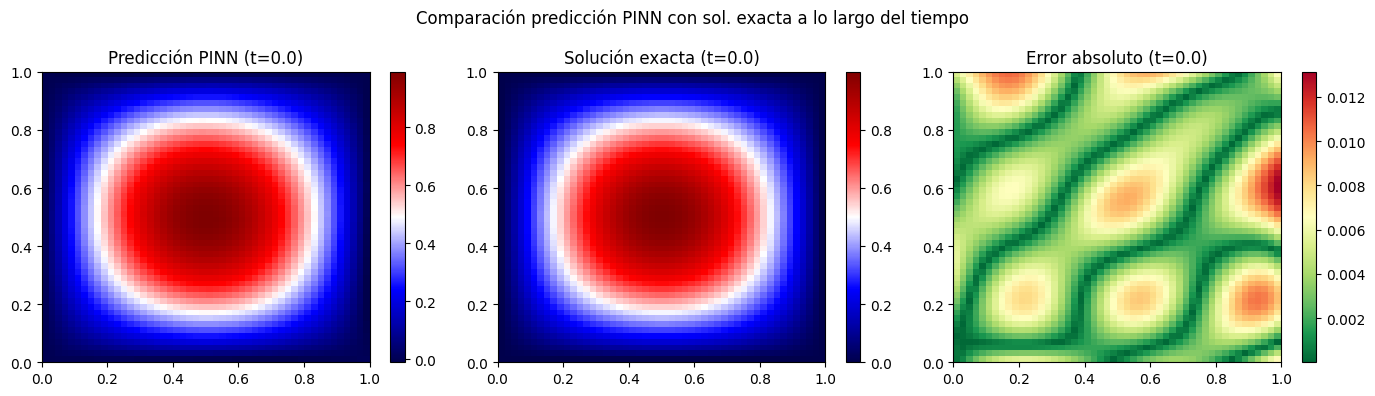

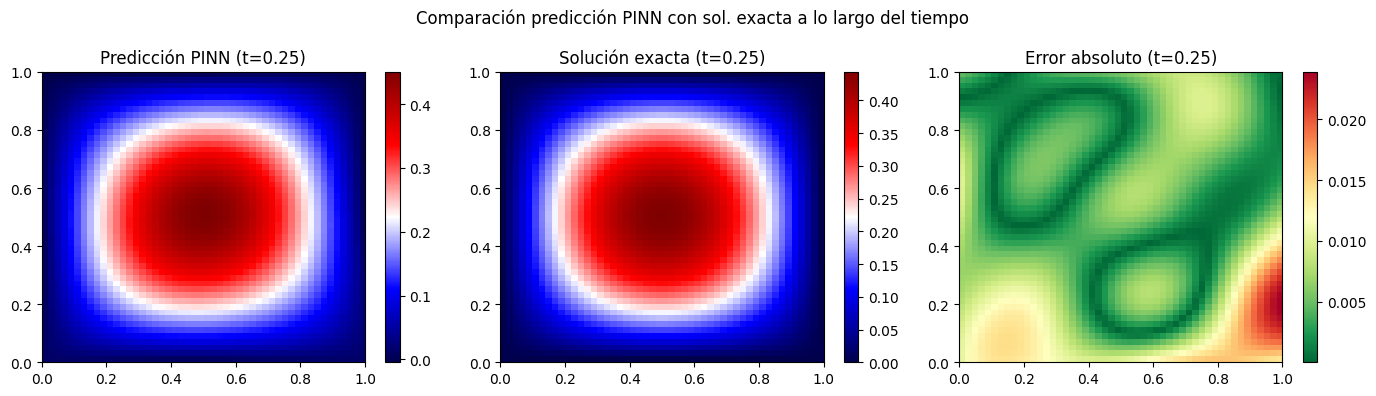

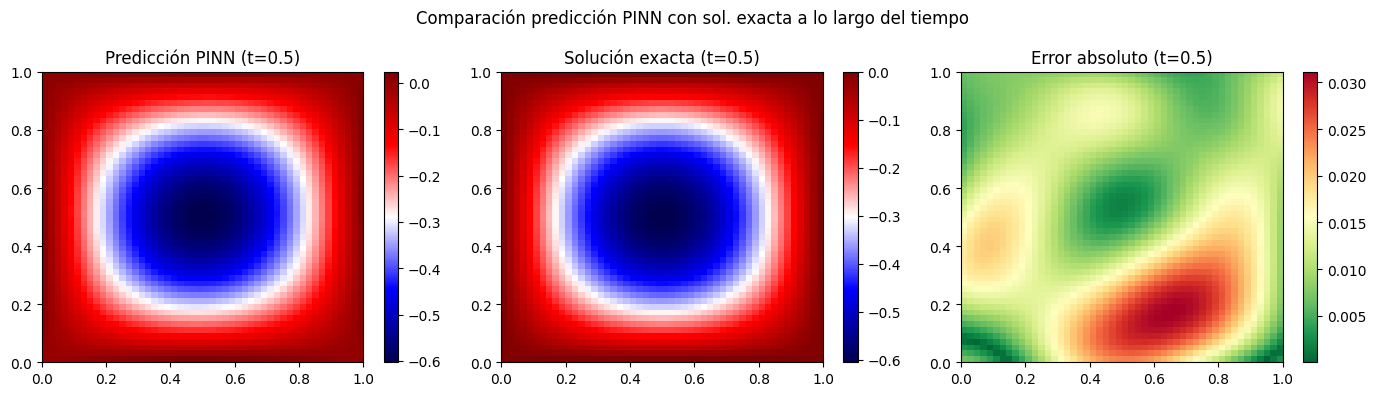

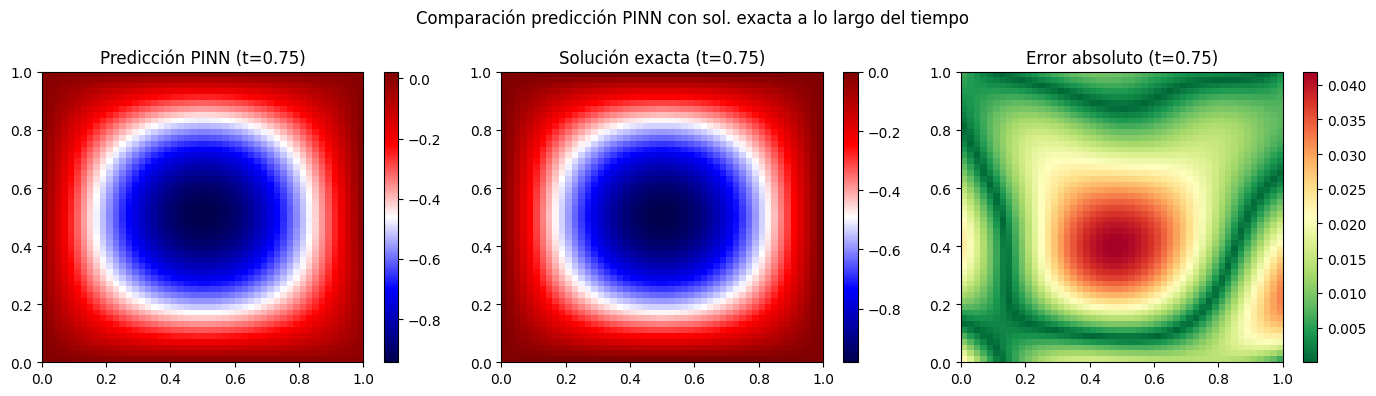

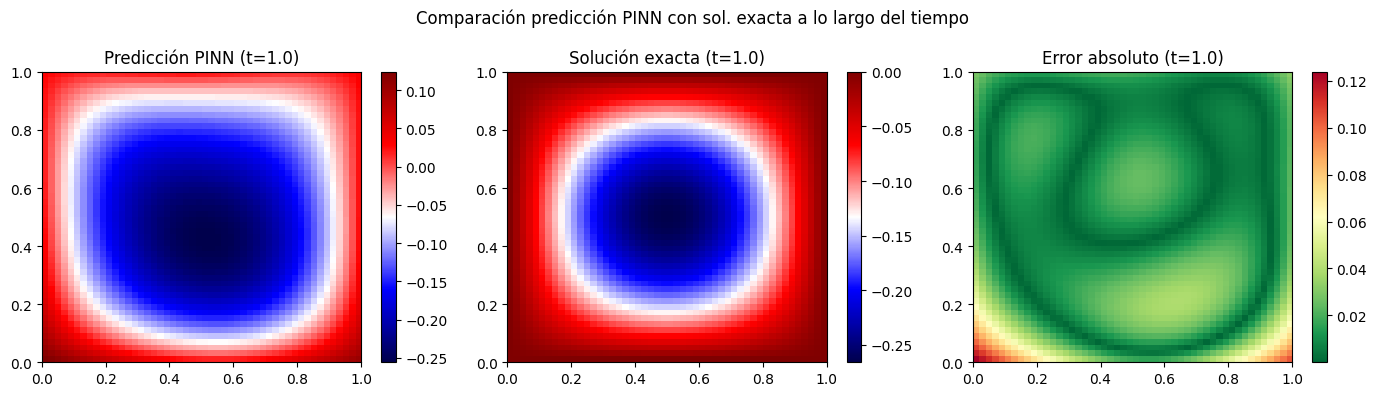

In [20]:
Nx, Ny = 50, 50  # Puntos en cada dimensión espacial
x_vals = torch.linspace(0, 1, Nx)
y_vals = torch.linspace(0, 1, Ny)

# Construcción malla
X, Y = torch.meshgrid(x_vals, y_vals, indexing='ij')  # Forma: [Nx, Ny]

# Tiempos para evaluar
time_snapshots = [0.0, 0.25, 0.5, 0.75, 1.0]

for t_plot in time_snapshots:
    X_flat = X.reshape(-1, 1)
    Y_flat = Y.reshape(-1, 1)
    T_flat = torch.full_like(X_flat, t_plot)

    # Paso por la red
    with torch.no_grad():
        u_pred_flat = model(torch.cat([X_flat.to('cuda'), Y_flat.to('cuda'), T_flat.to('cuda')], dim=1))  # shape [Nx*Ny, 1]

    # Volver a poner las predicciones (Nx, Ny) a forma original
    u_pred = u_pred_flat.reshape(Nx, Ny)

    # Solución exacta
    u_exact = exact_solution(X.to('cuda'), Y.to('cuda'), torch.tensor(t_plot).to('cuda'), c=1.0)  # shape [Nx, Ny]

    # Error absoluto
    diff = (u_pred - u_exact).abs()

    # Gráfica
    fig, axes = plt.subplots(1, 3, figsize=(14, 4))
    fig.suptitle("Comparación predicción PINN con sol. exacta a lo largo del tiempo ")

    # Solución PINN
    c0 = axes[0].imshow(u_pred.detach().cpu().numpy(), origin='lower', extent=[0, 1, 0, 1], aspect='auto', cmap='seismic')
    axes[0].set_title(f'Predicción PINN (t={t_plot})')
    plt.colorbar(c0, ax=axes[0])

    # Solución exacta
    c1 = axes[1].imshow(u_exact.detach().cpu().numpy(), origin='lower', extent=[0, 1, 0, 1], aspect='auto', cmap='seismic')
    axes[1].set_title(f'Solución exacta (t={t_plot})')
    plt.colorbar(c1, ax=axes[1])

    # Diferencia en valor absoluto
    c2 = axes[2].imshow(diff.detach().cpu().numpy(), origin='lower', extent=[0, 1, 0, 1], aspect='auto', cmap='RdYlGn_r')
    axes[2].set_title(f'Error absoluto (t={t_plot})')
    plt.colorbar(c2, ax=axes[2])

    plt.tight_layout()
    plt.show()


/tmp/ipython-input-22-3305234301.py:38: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


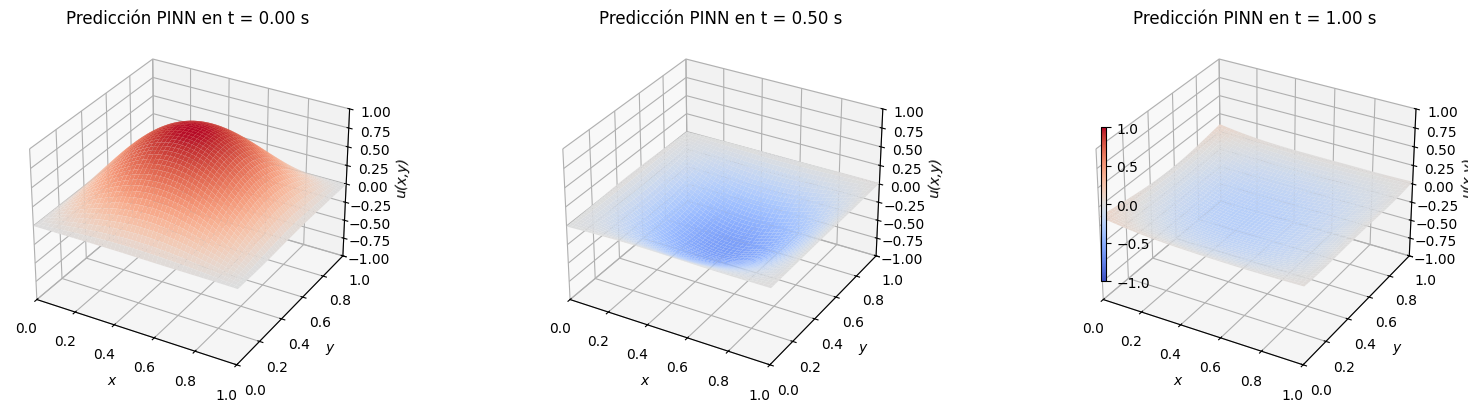

In [22]:
from mpl_toolkits.mplot3d import Axes3D

# Asumimos que ya tienes: X, Y de tamaño [Nx, Ny], u_pred con forma [Nx, Ny] en cada snapshot
# También suponemos que los valores de x_vals y y_vals están en [0, 1]
x_np = x_vals.cpu().numpy()
y_np = y_vals.cpu().numpy()
X_np, Y_np = np.meshgrid(x_np, y_np,indexing='ij')
# Preparar para graficar tres snapshots: t0, tm, t1
snapshot_indices = [0, len(time_snapshots) // 2, -1]

fig = plt.figure(figsize=(16, 4))

for i, idx in enumerate(snapshot_indices):
    t_plot = time_snapshots[idx]

    # Generar datos para este tiempo
    X_flat = X.reshape(-1, 1)
    Y_flat = Y.reshape(-1, 1)
    T_flat = torch.full_like(X_flat, t_plot)

    with torch.no_grad():
        u_pred_flat = model(torch.cat([X_flat.to('cuda'), Y_flat.to('cuda'), T_flat.to('cuda')], dim=1))

    u_pred = u_pred_flat.reshape(Nx, Ny).cpu().numpy()

    # Subgráfico 3D
    ax = fig.add_subplot(1, 3, i+1, projection='3d')
    surf = ax.plot_surface(X_np, Y_np, u_pred, cmap='coolwarm', linewidth=0, vmin=-1, vmax=1)
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.set_zlim(-1, 1)
    ax.set_xlabel("x", fontstyle="italic")
    ax.set_ylabel("y", fontstyle="italic")
    ax.set_zlabel("u(x,y)", fontstyle="italic")
    ax.set_title(f"Predicción PINN en t = {t_plot:.2f} s")

fig.colorbar(surf, ax=fig.axes, shrink=0.5, aspect=30)
plt.tight_layout()
plt.show()

### Animación:

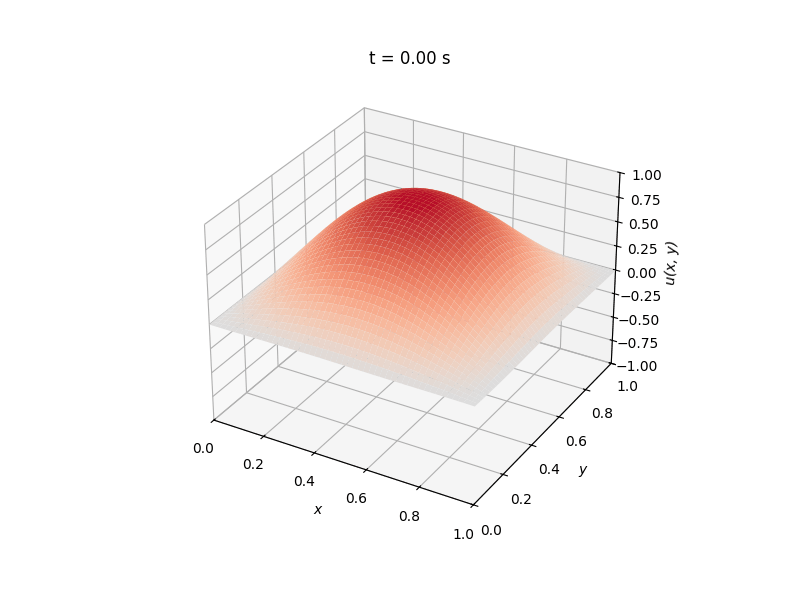

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

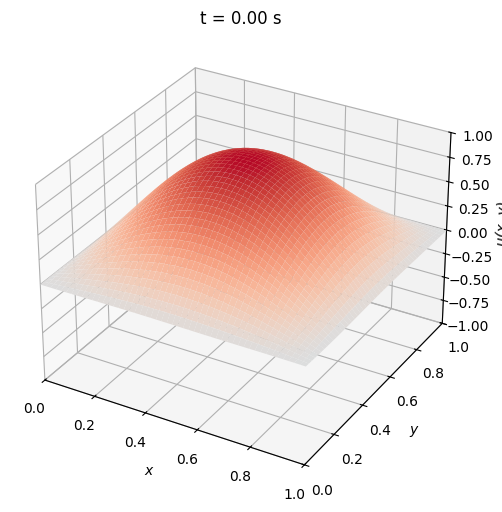

In [25]:
# Convertimos la malla a numpy para graficar
X_np = X.cpu().numpy()
Y_np = Y.cpu().numpy()

# Calculamos u_pred para todos los tiempos y almacenamos en tensor
u_pred_all = []

for t_plot in time_snapshots:
    X_flat = X.reshape(-1, 1)
    Y_flat = Y.reshape(-1, 1)
    T_flat = torch.full_like(X_flat, t_plot)

    with torch.no_grad():
        u_pred_flat = model(torch.cat([X_flat.to('cuda'), Y_flat.to('cuda'), T_flat.to('cuda')], dim=1))
    u_pred_t = u_pred_flat.reshape(Nx, Ny).cpu()
    u_pred_all.append(u_pred_t)

# Creamos tensor de forma (Nx, Ny, frames)
u_pred_all = torch.stack(u_pred_all, dim=2)

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection='3d')

def animate(i):
    ax.clear()
    ax.plot_surface(X_np, Y_np, u_pred_all[:, :, i].numpy(), cmap='coolwarm', linewidth=0, vmin=-1, vmax=1)
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.set_zlim(-1, 1)
    ax.set_xlabel("x", fontstyle="italic")
    ax.set_ylabel("y", fontstyle="italic")
    ax.set_zlabel("u(x, y)", fontstyle="italic")
    ax.set_title(f"t = {time_snapshots[i]:.2f} s")

anim = FuncAnimation(fig, animate, frames=len(time_snapshots), interval=200)

anim.save('onda_2D_PINN.gif', writer='pillow', fps=5)

from IPython.display import Image, display
display(Image(filename='onda_2D_PINN.gif'))

from google.colab import files
files.download('onda_2D_PINN.gif')